In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

sys.path.append("../")
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [33]:
useNet='MLP4'
iterations=30
learningRate=1e-2
verbose=True
doInitWeights=False
pDropout=0

# First, select device to run networks on
if DEVICE is None:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"
print(f"Initiating experiment using {DEVICE}")

# Prepare Network and Preprocessing
batchSize = 1000
weightvars = None # initialize variance of weights with default parameters
if useNet=='CNN2P2':
    convActivation = F.relu
    linearActivation = F.relu
    net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    ])
elif useNet=='MLP3':
    actFunc = F.relu
    net = models.MLP3(actFunc=actFunc)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
elif useNet=='MLP4':
    actFunc = F.relu
    net = models.MLP4(actFunc=actFunc,pDropout=pDropout)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
else:
    raise ValueError('useNet not recognized')

net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
# optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

# Store initial network weights to view how things change over training
initWeights = net.getNetworkWeights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,(images,label) in enumerate(trainloader):
        cidx = epoch*len(trainloader) + idx # stores idx of each "miniepoch" 

        # move batch to GPU (if available) 
        images, label = images.to(DEVICE), label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Measure Alignment of weights using current images in batch as a sample
        alignFull.append(net.measureAlignment(images))

        # Measure Change in Weights
        deltaWeights.append(net.compareNetworkWeights(initWeights))

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

    # Print statistics for each epoch
    if verbose: print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))

# Measure performance on test set
totalLoss = 0
numCorrect = 0
numAttempted = 0
for batch in testloader:
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    outputs = net(images)
    totalLoss += loss_function(outputs,label).item()
    output1 = torch.argmax(outputs,axis=1)
    numCorrect += sum(output1==label)
    numAttempted += images.shape[0]

print(f"Average loss over test set: %.2f." % (totalLoss / len(testloader)))
print(f"Accuracy over test set: %.2f%%." % (100*numCorrect/numAttempted))
print('Training process has finished in %.3f seconds.' % (time.time()-t))

results = {
    'net':net,
    'initWeights':initWeights,
    'alignFull':alignFull,
    'deltaWeights':deltaWeights,
    'trackLoss':trackLoss,
    'trackAccuracy':trackAccuracy,
    'trainloader':trainloader,
    'testloader':testloader,
    'learningRate':learningRate,
}

Initiating experiment using cuda
Loss in epoch   0: 2.260, Accuracy: 18.20%.
Loss in epoch   1: 2.198, Accuracy: 34.90%.


In [ ]:
# (numLayers, numMiniEpochs) returns average alignment for each layer for each mini-epoch
alignMean = net.avgFromFull(alignFull) 

# [(numNodes, numMiniEpochs) for layer in numLayers] for each layer, return the alignment of each network node for each mini-epoch
alignLayer = [net.layerFromFull(alignFull,layer) for layer in range(net.numLayers)] 

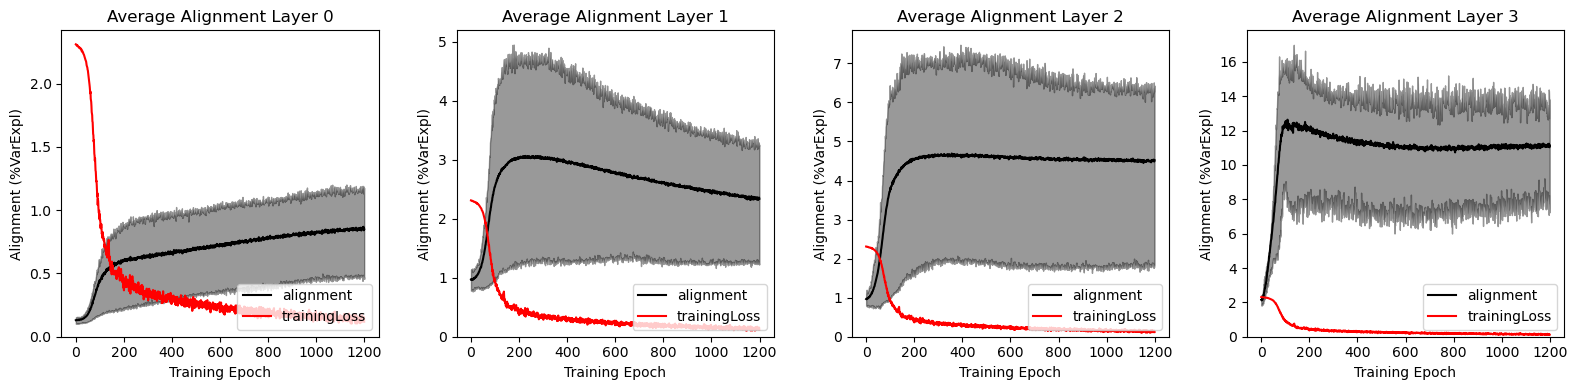

In [ ]:
totalEpochs = iterations * len(trainloader)

qRange = (0.3, 0.7)
fig, ax = plt.subplots(1,net.numLayers, figsize=(16,4))
for layer in range(net.numLayers):
    # get upper and lower quantile of alignment for each layer
    uq = torch.quantile(alignLayer[layer],q=qRange[1],dim=0)
    lq = torch.quantile(alignLayer[layer],q=qRange[0],dim=0)

    # plot average alignment for each layer (scale to % of variance)
    ax[layer].plot(range(totalEpochs), 100*alignMean[layer], color='k', linewidth=1.5, label='alignment')
    
    # plot quantile range of alignment for each layer (scale to % of variance)
    ax[layer].fill_between(range(totalEpochs), 100*uq, 100*lq, color='k', alpha=0.4)

    ax[layer].plot(range(totalEpochs), trackLoss, color='r', linewidth=1.5, label='trainingLoss')

    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    ax[layer].legend(loc='lower right')
    
plt.tight_layout()

In [ ]:
# Measure Activations (without dropout) for all images
storeDropout = net.getDropout()
net.setDropout(0) # no dropout for measuring eigenfeatures
allimages = []
activations = []
for images, label in tqdm(trainloader):    
    allimages.append(images)
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    # this is a huge list of the activations across all layers for each image in the data
    activations.append(net.getActivations(images)) 
net.setDropout(storeDropout)

print(len(activations)) # number of batches in trainLoader
print(len(activations[0])) # number of layers in network
print([a.shape for a in activations[0]]) # (batchSize x nodesPerLayer) for each layer

100%|██████████| 60/60 [00:04<00:00, 14.10it/s]

60
4
[torch.Size([1000, 100]), torch.Size([1000, 100]), torch.Size([1000, 50]), torch.Size([1000, 10])]


In [ ]:
# Consolidate variable structure
# allinputs is a numLayers element list containing the input to each layer for every image
# the first element (allinputs[0]) is just the images
# every next element is the post-activations of each successive layer in the network
NL = net.numLayers
allinputs = []
allinputs.append(torch.cat(allimages,dim=0).detach().cpu())
for layer in range(NL-1):
    allinputs.append(torch.cat([cact[layer] for cact in activations],dim=0).detach().cpu())
    
for ai in allinputs: print(ai.shape)

torch.Size([60000, 784])
torch.Size([60000, 100])
torch.Size([60000, 100])
torch.Size([60000, 50])


In [ ]:
# Measure eigenfeatures for each layer
# Now, we can measure the eigenvalues of the input to each layer
eigenvalues = []
eigenvectors = []
for ai in allinputs:
    w,v = sp.linalg.eigh(torch.cov(ai.T))
    widx = np.argsort(w)[::-1]
    w = w[widx]
    v = v[:,widx]
    eigenvalues.append(w)
    eigenvectors.append(v)
for evl,evc in zip(eigenvalues,eigenvectors):
    print(f"EVal Shape: {evl.shape}, EVec Shape: {evc.shape}")

EVal Shape: (784,), EVec Shape: (784, 784)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (50,), EVec Shape: (50, 50)


In [ ]:
# Measure dot product of weights for each layer
# The dot product of the weight for each layer with the eigenvectors of the input to each layer
# tells us what fraction of the weight for each node comes from each eigenvector!
beta = []
netweights = net.getNetworkWeights()
for evc,nw in zip(eigenvectors,netweights):
    nw = nw / torch.norm(nw,dim=1,keepdim=True)
    beta.append(torch.abs(nw.cpu() @ evc))
for b in beta: print(b.shape)

torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([50, 100])
torch.Size([10, 50])


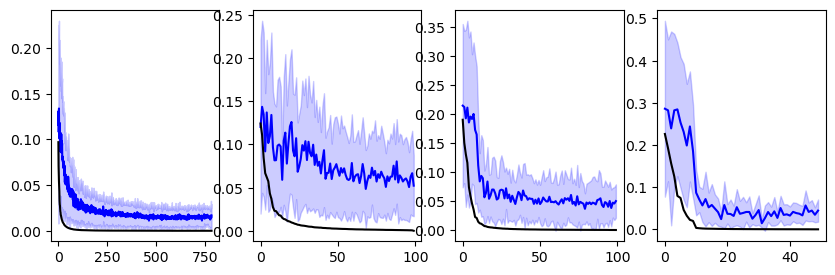

In [ ]:
# Compare the eigenvalues of the input to each layer with the betas of the weight vectors for each eigenvector
# The black line is the eigenvalues. It tells us the variance structure of the input to each layer --
# -- specifically, it tells us which dimensions of the input contain significant variance
# The blue lines are the average +/- std dot product ("beta") between the weights of each layer and the eigenvectors of the input to each layer --

# Note: 
# note that the blue curve is a lot higher than the black curve -- that means that the network is using eigenvectors that explain very little variance!! (weird)
# ----- I think this might be relevant for understanding how adversarial attacks work...

fig,ax = plt.subplots(1,NL,figsize=(10,3))

for layer in range(NL):
    cNEV = len(eigenvalues[layer])
    mnbeta = torch.mean(beta[layer],dim=0)
    sebeta = torch.std(beta[layer],dim=0)
    ax[layer].fill_between(range(cNEV), mnbeta+sebeta, mnbeta-sebeta, color='b', alpha=0.2)
    ax[layer].plot(range(cNEV), mnbeta, c='b', label='AverageProjection')
    ax[layer].plot(range(cNEV), eigenvalues[layer]/np.sum(eigenvalues[layer]), c='k', label='Eigenvalues')
    ax[layer].set_xscale('linear')
    # ax[layer].set_yscale('log')